### Setup Code

In [ ]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All libraries we need in homework 5

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

### 1.2 Experiment
The clustering objective $J$ of K-Means algorithm is $J = \sum_{i}^{n}\sum_{i \in \mu_k}^{K}\|X_{I} - \mu_{k}\|^2$. In sklearn, by "KMeans.score" we can get the negative J for the dataset. And for GMM, the clustering objective is the negative log likelihood.

In this implement, function "assign_label" is to assign the corresponding true label for given centroids or means.

In [ ]:
'''
Generate data sets
Input: 
  - sigma

Output:
  - dataset from (Pa, Pb, Pc)
'''

def generate_data(sigma):
  pa_mean = np.array([-1,-1])
  pa_cov = np.array([[2,0.5],[0.5,1]])

  pb_mean = np.array([1,-1])
  pb_cov = np.array([[1,-0.5],[-0.5,2]])

  pc_mean = np.array([0,1])
  pc_cov = np.array([[1,0],[0,2]])

  Pa = np.random.multivariate_normal(pa_mean, sigma*pa_cov, 100)
  Pb = np.random.multivariate_normal(pb_mean, sigma*pb_cov, 100)
  Pc = np.random.multivariate_normal(pc_mean, sigma*pc_cov, 100)

  dataset = np.concatenate([np.array(Pa),np.array(Pb),np.array(Pc)])
  return dataset

'''
Assign index of label，
Input:
  - gm.means_: the result of GMM
Output:
  - array: (id_for_pa*100, id_for_pb*100, id_for_pc*100)
'''

def assgin_index(gm_mean):
  pa_mean = np.array([-1,-1])
  pb_mean = np.array([1,-1])
  pc_mean = np.array([0,1])
  targets = [pa_mean,pb_mean,pc_mean]

  id_list = np.array([])
  for target in targets:
    id = -1
    dis = 101
    min_dis = 100
    for i in range(0,3):
      dis = np.sum((target-gm_mean[i])**2)
      if dis < min_dis:
        min_dis = dis
        id = i
    id_list = np.append(id_list,np.repeat(id,100))

  return id_list

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics

sigmas = [0.5,1,2,4,8]
k = 3

kmeans_clustering_objectives = []
kmeans_clustering_accuracy = []

GMM_clustering_objectives = []
GMM_clustering_accuracy = []

for sigma in sigmas:
  dataset = generate_data(sigma=sigma)
  gm = GaussianMixture(n_components=k, random_state=0).fit(dataset)
  km = KMeans(n_clusters=k,n_init='auto',random_state=0).fit(dataset)

  label_true = assgin_index(gm.means_)
  GMM_clustering_accuracy.append(metrics.accuracy_score(label_true,gm.predict(dataset)))
  GMM_clustering_objectives.append(gm.score(dataset))

  label_true = assgin_index(km.cluster_centers_)
  kmeans_clustering_accuracy.append(metrics.accuracy_score(label_true,km.predict(dataset)))
  kmeans_clustering_objectives.append(km.score(dataset))

Plot sigma v.s. clustering_accuracy 

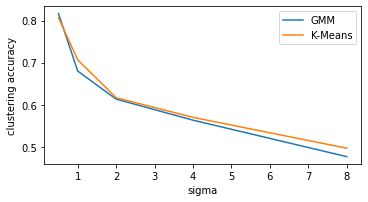

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(sigmas,GMM_clustering_accuracy,label="GMM")
ax.plot(sigmas,kmeans_clustering_accuracy,label="K-Means")
ax.set_xlabel('sigma')
ax.set_ylabel('clustering accuracy')
ax.legend()

Consider the different range of clustering objectives, I choose two plots to show them.

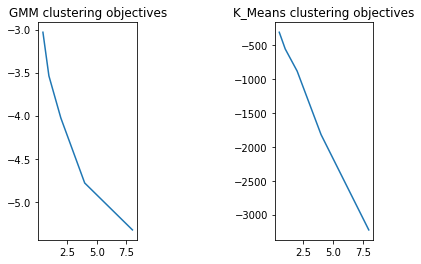

In [ ]:
plt.subplot(1,3,1)
plt.plot(sigmas,GMM_clustering_objectives)
plt.title('GMM clustering objectives')

plt.subplot(1,3,3)
plt.plot(sigmas,kmeans_clustering_objectives)
plt.title('K_Means clustering objectives')

plt.show()

###Experiment 2-4

In [85]:
'''
load data
'''

def load_data():
  dir1 = "/content/drive/My Drive/CS760/hw5_data/data2D.csv"
  dir2 = "/content/drive/My Drive/CS760/hw5_data/data1000D.csv"

  data2D = pd.read_csv(dir1,header=None)

  data1000D = pd.read_csv(dir2,header=None)
  
  return data2D.values, data1000D.values

In [86]:
data1,data2 = load_data()

####Problem 1
Without centering and normalization, the eigenvalues and eigenvectors of the data may not be correctly sorted and the magnitude of variances do not correspond to the magnitude of eigenvectors in a one-to-one manner, which may lead to wrong ranking of principal components. 

Three variants of PCA

In [197]:
'''
Subtract the mean along each dimension
Input:
  - X: data set
Output:
  - X_c: X subtracted the mean
'''
def subtract_mean(X):
  X_mean = np.mean(X, axis=0)
  X_c = X - X_mean
  return X_c


'''
Scale each dimension of X
Input:
  - X_c: X whose sample mean is 0
Output:
  - X_scaled: X whose sample mean is 0 and deviation of each dimension is 1
'''
def scale_deviation(X_c):
  X_deviation = np.std(X_c, axis=0)
  X_scaled = X_c/X_deviation
  return X_scaled

In [192]:
from numpy.linalg.linalg import norm
'''
If demeaned = False and normalized = False, it is buggy PCA
If demeaned = True and normalized = False, it is demeaned PCA
If normalized = True, it is normalized PCA
Input:
  - X: data
  - d: lower dimensions
  - demeaned: whether to subtract the mean
  - normalized: whether to normalize the data
Output:
  - X_pca
  - Vt
'''
def PCA(X,d,demeaned = False, normalized = False):
  if normalized:
    demeaned = True

  tmp_X = np.array(X)
  if demeaned:
    tmp_X = subtract_mean(X)

  if normalized:
    tmp_X = scale_deviation(tmp_X)

  cov_matrix = np.cov(tmp_X.T)

  U, s, Vt = np.linalg.svd(tmp_X)

  V = Vt[:d].T
  X_pca = tmp_X.dot(V)

  return X_pca, V


'''
Reconstruction function
Input:
  - X_pca
  - X: raw data to calculate mean and std
  - V: the matrix for reconstruction
  - d: d dimensions
  - demeaned: whether to subtract the mean
  - normalized: whether to normalize the data
Output:
  - X_recon: reconstucted data
  - recon_errors: reconstuction errors
'''

def recon_PCA(X_pca, V, X, d, demeaned = False, normalized = False):
  if normalized:
    demeaned = True

  mean = np.mean(X,axis=0)
  std = np.std(X,axis=0)

  # X_recon = X_pca.dot(V[:d,:])
  X_recon = X_pca.dot(V.T)

  if normalized:
    X_recon *= std

  if demeaned:
    X_recon += mean

  # X_recon = X_recon + mean

  recon_errors = np.sum((X - X_recon) ** 2)/50

  return X_recon, recon_errors

0.8869030837347942


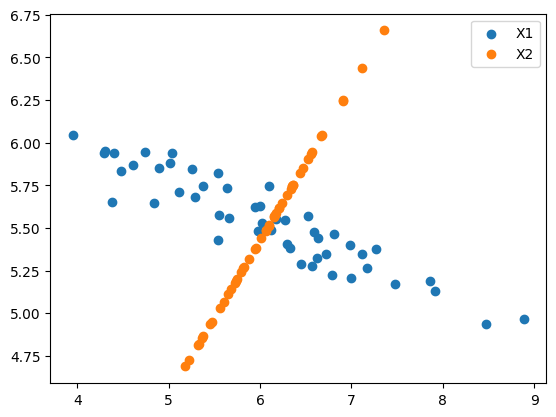

In [193]:
X_pca, V= PCA(data1,d=1)
X_recon, recon_errors = recon_PCA(X_pca=X_pca,V=V,X=data1,d=1)
print(recon_errors)

plt.scatter(data1[:,0], data1[:,1], label='X1')  
plt.scatter(X_recon[:,0], X_recon[:,1], label='X2')
plt.legend()
plt.show()

0.010006085628512906


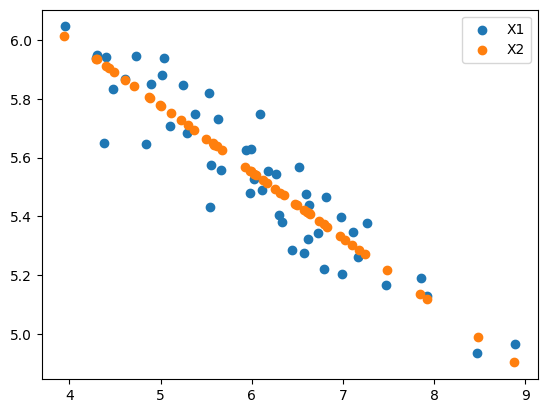

In [194]:
X_pca, V= PCA(data1,d=1,demeaned=True)
X_recon, recon_errors = recon_PCA(X_pca=X_pca,V=V,X=data1,d=1,demeaned=True)
print(recon_errors)

plt.scatter(data1[:,0], data1[:,1], label='X1')  
plt.scatter(X_recon[:,0], X_recon[:,1], label='X2')
plt.legend()
plt.show()

0.04947208345477067


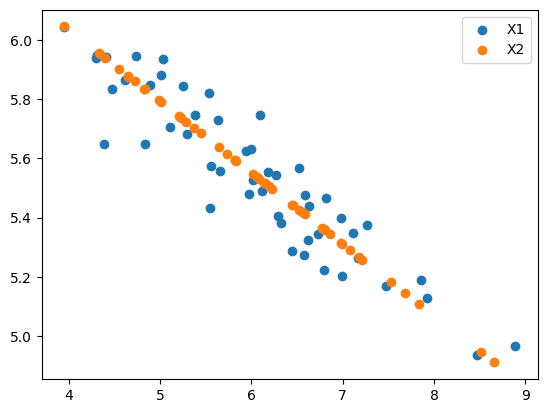

In [198]:
X_pca, V= PCA(data1,d=1,normalized=True)
X_recon, recon_errors = recon_PCA(X_pca=X_pca,V=V,X=data1,d=1,normalized=True)
print(recon_errors)

plt.scatter(data1[:,0], data1[:,1], label='X1')  
plt.scatter(X_recon[:,0], X_recon[:,1], label='X2')
plt.legend()
plt.show()

DRO and DRLV